# Predictive Health Insurance Model for Shield Insurance 

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score



In [157]:
df=pd.read_excel("premiums.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [158]:
df.shape

(50000, 13)

### 🧹 **Data Cleaning Process:**

To ensure our dataset is ready for analysis, we need to perform some **data cleaning** tasks. This involves:

1. **Column Name Cleaning**: Ensure column names are in a consistent format.
2. **Handling Negative Values**: Investigating and fixing negative values in the "Number of Dependants" column.
3. **Descriptive Statistics**: Generating a summary of the data for better understanding.

Let’s dive into the steps!


In [159]:
# Cleaning up column names by replacing spaces with underscores for consistency
df.columns=df.columns.str.replace(" ","_").str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

#### 1. **Column Name Cleaning**:
We started by cleaning the column names. Spaces in column names were replaced with underscores to maintain consistency and make it easier to work with. This step helps prevent potential issues when referencing columns in the future.


In [160]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.593480,1.712080,23.018200,15768.116320
std,15.000437,1.498248,24.219197,8419.839675
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13929.000000
75%,45.000000,3.000000,31.000000,22275.250000
max,356.000000,5.000000,930.000000,43471.000000


#### 2. **Why  Negative Values in 'Number of Dependants' ?**:
As we review the data, we notice some negative values in the **"Number_Of_Dependants"** column. Let’s explore this part further to understand the extent of the issue.


In [161]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [162]:
df=df.dropna()
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [163]:
# Checking the rows where the 'Number_Of_Dependants' column has negative values
df[df["number_of_dependants"]<0].shape

(72, 13)

In [164]:
df[df["number_of_dependants"]<0]["number_of_dependants"].unique()

array([-3, -1], dtype=int64)

#### 3. **Handling Negative Values**:
Upon investigation, we find that there are **72 rows** with negative values in the "Number_Of_Dependants" column. However, **only two unique values** are causing the issue. Instead of deleting all these rows, which could result in losing useful data, we decide to correct the values by changing them to positive values.
- We could contact the data creators to clarify if these values are errors. However, for this analysis, we'll proceed by converting these negative values into their absolute values to retain the data.


In [165]:
# Converting negative values in 'Number_Of_Dependants' to positive
df["number_of_dependants"]=abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

## 🔍 **Outlier Treatment:**

In [166]:
numerical_columns=df.select_dtypes(["float64",'int64']).columns.tolist()
numerical_columns


['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

In [167]:
def format_ticks(value, _):
    return f"{int(value/1000)}K" if value >= 1000 else str(int(value))

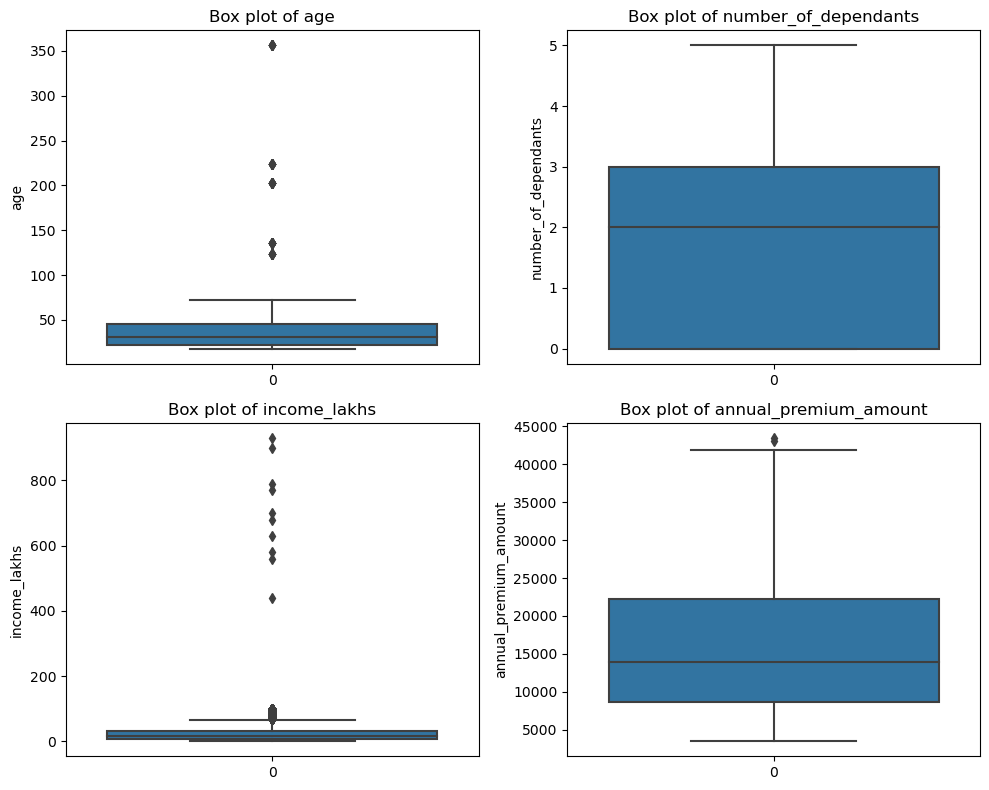

In [168]:
num_cols=len(numerical_columns)
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,8))

# ploting each graph
for i ,col in enumerate(numerical_columns):
    ax=axes[i//2,i%2]
    sns.boxplot(data=df[col], ax=ax)
    ax.set_title(f'Box plot of {col}')
    ax.set_xlabel("")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()
    

    
    

### 📊 **Boxplot Insights:**

The boxplots reveal some interesting trends:

- 🧑‍🤝‍🧑 **Age & Income**: Both columns show noticeable **outliers**. These could be worth investigating further! 🚨
- 💳 **Premium Amount**: Only a few outliers here, but they’re pretty insignificant. Let’s just **ignore** them for now. 🧹


## 🧑‍⚖️ **Age Column Cleaning**:

In the **Age** column, we noticed some entries above 100 years. Let's take a closer look at these extreme values.

In [169]:
## age column 
df[df["age"]>100]["age"].unique()


array([224, 124, 136, 203, 356], dtype=int64)

In [170]:
## remove those whose age is greater than 100

df1=df[df["age"]<=100].copy()
df1.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [171]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


## 💸 **Income Column Cleaning**:

In this section, we will clean the **Income_Lakhs** column by handling outliers based on the **Interquartile Range (IQR)** method, and further adjust the threshold as needed.

---

## 🔍 **Defining IQR Bounds**:

To detect outliers, we first calculate the **Interquartile Range (IQR)**. This helps us identify the bounds within which most of the data lies.


In [172]:
## lets treat the income column
## defining iqr bounds

def get_iqr_bounds(col):
    Q1,Q3=col.quantile([0.25,0.75])
    iqr=Q3-Q1
    lower_bound=Q1-1.5*iqr
    upper_bound=Q3+1.5*iqr
    return lower_bound,upper_bound
    

In [173]:
get_iqr_bounds(df["income_lakhs"])

(-29.0, 67.0)

### 🧠 Reassessing the Upper Bound:
After reviewing the results, we found that the upper bound of the **Income_Lakhs** column is **67 lakhs**, which is common in today's context.
To make this more relevant, we will increase the **threshold** to **1 crore (100 lakhs)**, which seems like a more reasonable upper limit.

In [174]:
## I think one crore would be a best threshold for this senario

quantile_threshold=df["income_lakhs"].quantile(0.999)
quantile_threshold

100.0

### 📊 Identifying Outliers Above the Threshold:
Let’s see how many rows have income values exceeding this new threshold.

In [175]:
## lets analyse how many more rows we have more than this threshold

df[df["income_lakhs"]>quantile_threshold].shape


(10, 13)

### 🧹 Cleaning the Income Column:
Since there are only a few rows with values above the threshold, we will drop them to ensure the data stays within a reasonable range.

In [176]:
## since there are few values only lets drop those 
df2=df1[df1["income_lakhs"]<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


### 📊 **Univariate Analysis**:

In this section, we will explore the distribution of the numeric columns in our cleaned dataset through **histograms** with **KDE** (Kernel Density Estimate) overlays. This will help us understand the spread and shape of the data.

---

### 👀 **Visualizing the Distribution of Numeric Columns**:

We will use **histograms** to visualize the frequency distribution of each numeric column, with an added **KDE** to provide a smoother estimate of the distribution. This will allow us to observe patterns like skewness, central tendency, and any potential outliers.


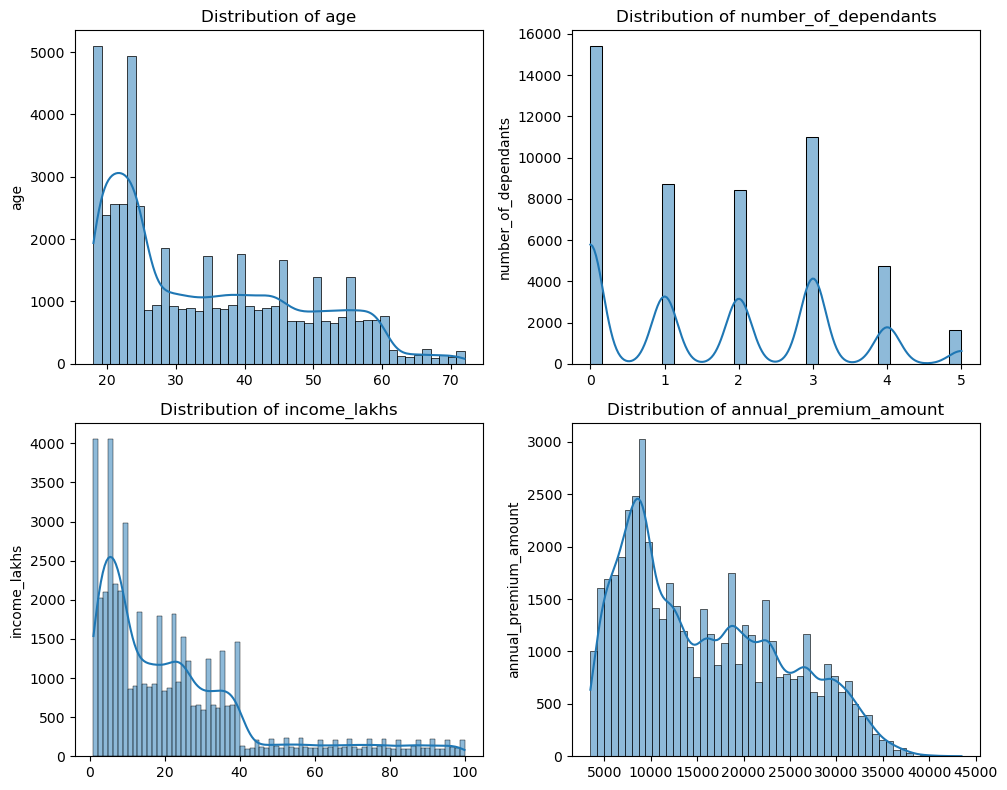

In [177]:
## visulaise the distribution of the numeric columns

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,8))

# ploting each graph
for i ,col in enumerate(numerical_columns):
    ax=axes[i//2,i%2]
    sns.histplot(data=df2[col], ax=ax,kde=True)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel("")
    ax.set_ylabel(col)
    # Apply y-tick formatting only for "income" column

plt.tight_layout()
plt.show()
    

### 🚀 Insights:

#### 1. 🧑‍🤝‍🧑 **Age Distribution**:
Looks like **most applicants** are in the **up-to-60 years** age range. 👴👵 (The majority are still in their prime!)

#### 2. 👨‍👩‍👧‍👦 **Number of Dependents**:
Surprisingly, **zero dependents** is the most common! 💯 (Guess it’s a no-kids or single-life vibe!)

#### 3. 💸 **Income Distribution**:
**Right-skewed** alert! 🚨 Most applicants are in the **up-to-40 lakh** range. Guess that’s where the money’s at? 💰

#### 4. 💳 **Annual Premium Amount**:
Another right-skewed situation! 🚀 **Most applicants** are chilling in the **10K premium range**. Keep it cool, keep it affordable! 😎


### 📊 Bivariate Analysis

---

#### Numeric columns

In [178]:
numeric_features=numerical_columns.copy()
numeric_features.remove("annual_premium_amount")
numeric_features

['age', 'number_of_dependants', 'income_lakhs']

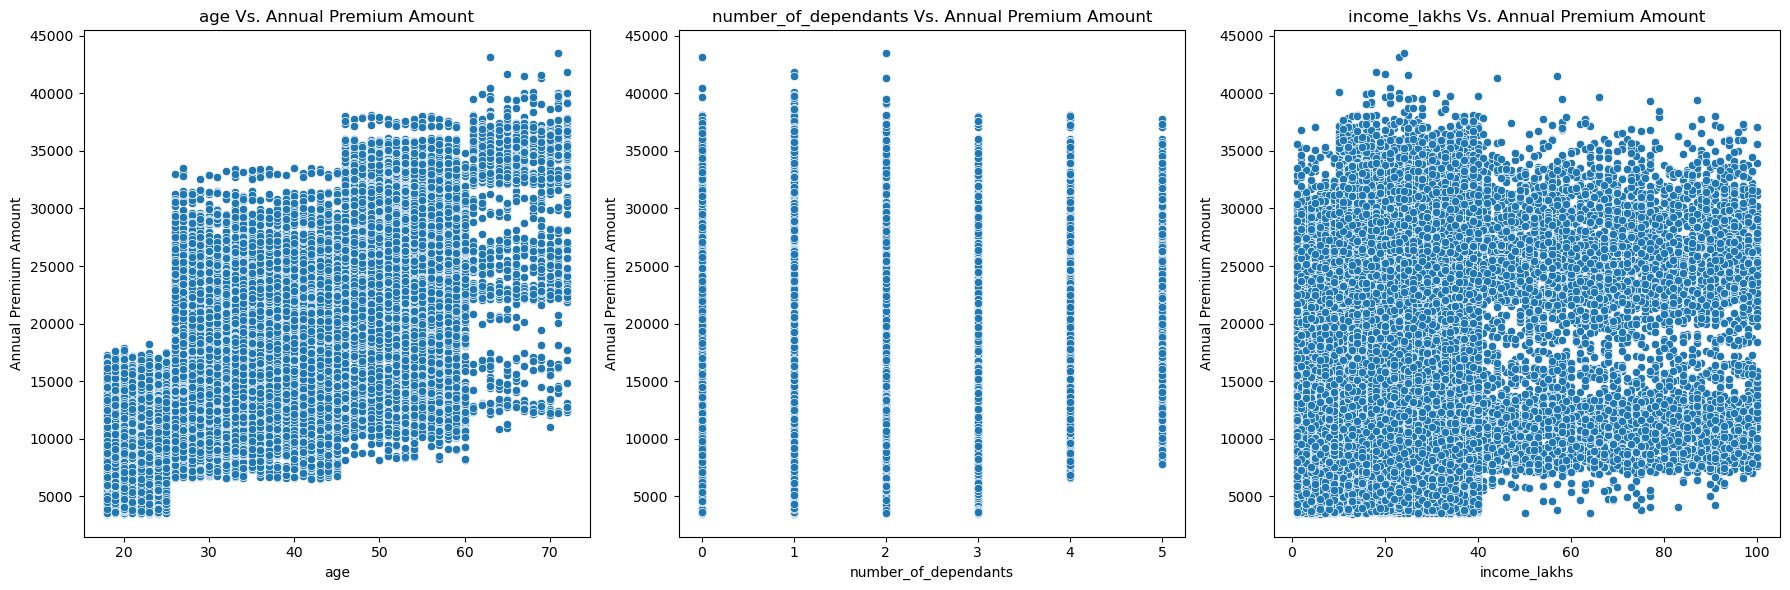

In [179]:
fig, axes=plt.subplots(1,len(numeric_features),figsize=(18,6))
for ax , col in zip(axes , numeric_features):
    sns.scatterplot(x=df2[col],y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f'{col} Vs. Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel('Annual Premium Amount')
plt.tight_layout()
plt.show()

### Categorical Columns

In [180]:
categorical_columns=df.select_dtypes(["object"]).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [181]:
## lets check the categorical columns
for col in categorical_columns:
    print(f'{col}:{df2[col].unique()}')
    print()

gender:['Male' 'Female']

region:['Northwest' 'Southeast' 'Northeast' 'Southwest']

marital_status:['Unmarried' 'Married']

bmi_category:['Normal' 'Obesity' 'Overweight' 'Underweight']

smoking_status:['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']

employment_status:['Salaried' 'Self-Employed' 'Freelancer']

income_level:['<10L' '10L - 25L' '> 40L' '25L - 40L']

medical_history:['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']

insurance_plan:['Bronze' 'Silver' 'Gold']



In [182]:
## Looks like the values in smoking status are not good lets fix them:
df2['smoking_status'].replace(
    {
        'Smoking=0':'No Smoking',
        'Does Not Smoke':"No Smoking",
        'Not Smoking':"No Smoking"
    }
    ,inplace=True
)
df2["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [183]:
pct_counts=df2['gender'].value_counts(normalize=True)
pct_counts

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

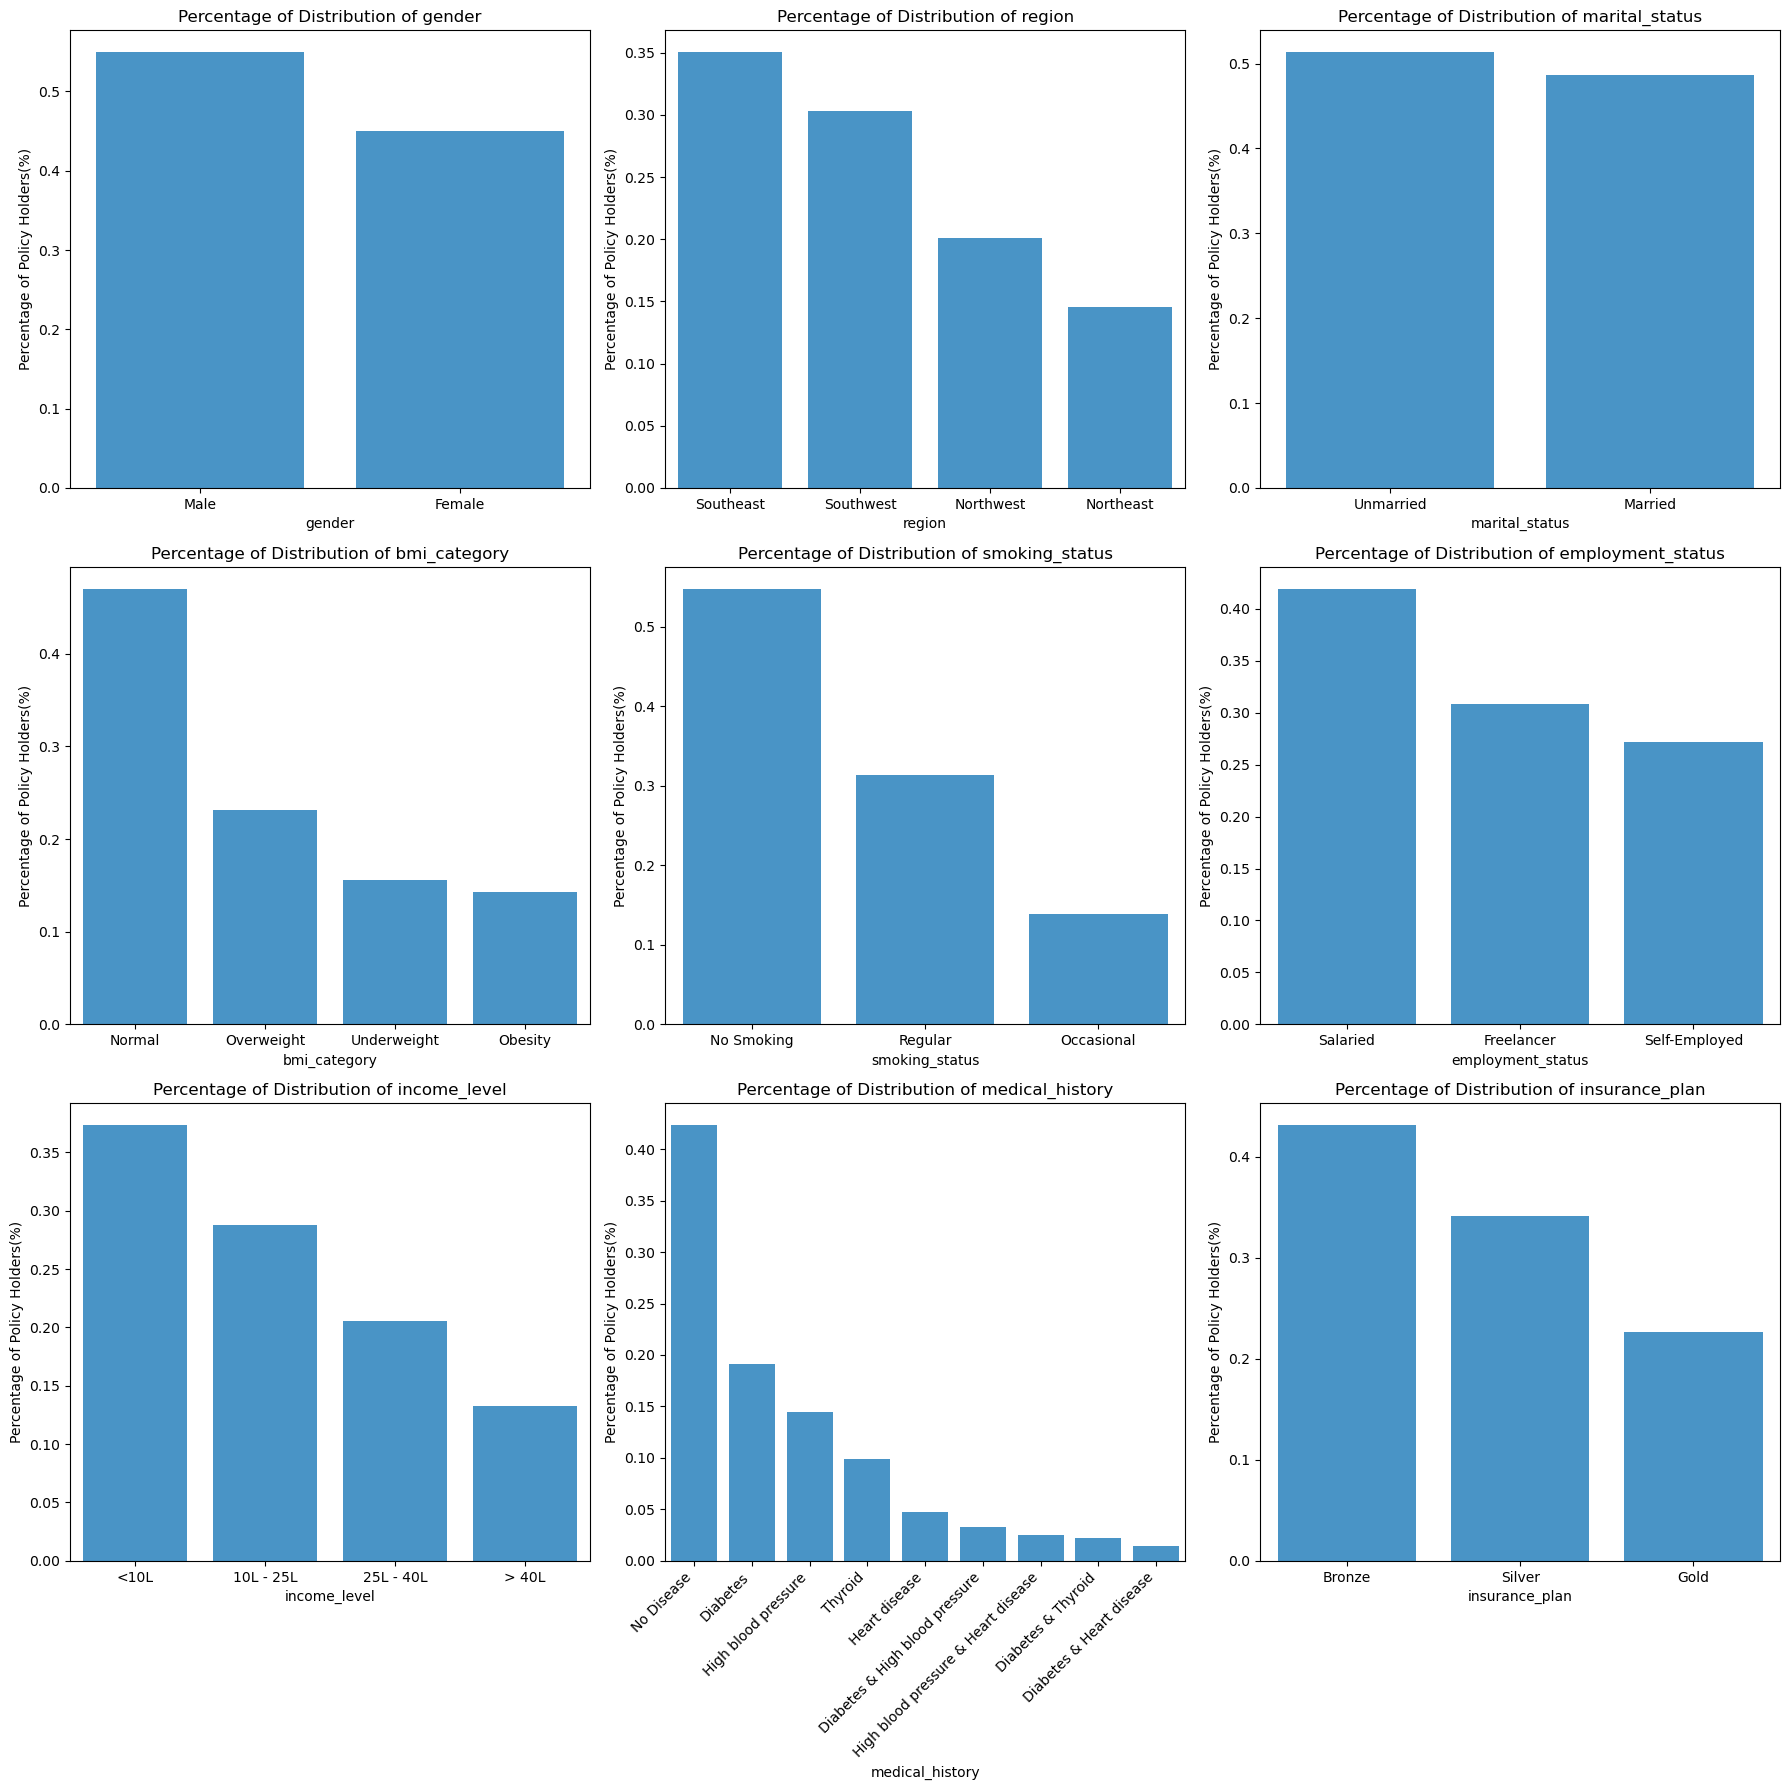

In [184]:
fig, axes=plt.subplots(3,3,figsize=(18,18))
axes=axes.flatten()
bar_color = "#3498db"
for ax , col in zip(axes , categorical_columns):
    # calculating the percentage distribution for each category
    category_counts=df2[col].value_counts(normalize=True)
    
    #creating bar plots
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax,color=bar_color)
    ax.set_title(f'Percentage of Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage of Policy Holders(%)')
    # Rotate x-axis labels if there are too many
    if len(category_counts) > 8:  
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 🧐 **Insights**

Based on the analysis, the following key insights have been identified:

---

### 👨‍💼 **Male Policyholders Outnumber Female Policyholders**
- There is a slight difference in the number of male policyholders compared to female policyholders, with males holding a majority.

### 🌍 **Regional Performance**
- The **Southeast** region stands out as the top-performing region, while the **Northeast** region has the least number of policyholders.

### 💍 **Marital Status Insights**
- **Unmarried policyholders** outnumber married ones, although the difference is quite small.

### 🏋️‍♀️ **BMI Insights**
- A significant proportion of policyholders fall under the **Normal BMI** category, standing out compared to other BMI categories.

### 🚭 **Smoking & Medical History**
- Policyholders with **no smoking habits** and **no disease medical histories** represent the majority, making these groups the most common among all categories.

### 💼 **Income and Employment Insights**
- A large number of policyholders are **salaried individuals** with an annual income **below 10 lakhs**, which is the most common demographic in the data.

### 🥇 **Plan Preferences**
- Most policyholders have opted for the **Bronze** insurance plan. This suggests that the company may benefit from running a campaign to encourage customers to consider upgrading to **Silver** or **Gold** plans, offering more comprehensive coverage.

---

These insights highlight trends and patterns that can inform future decision-making, marketing strategies, and customer engagement for insurance providers. 🚀


### Bivariate Analysis

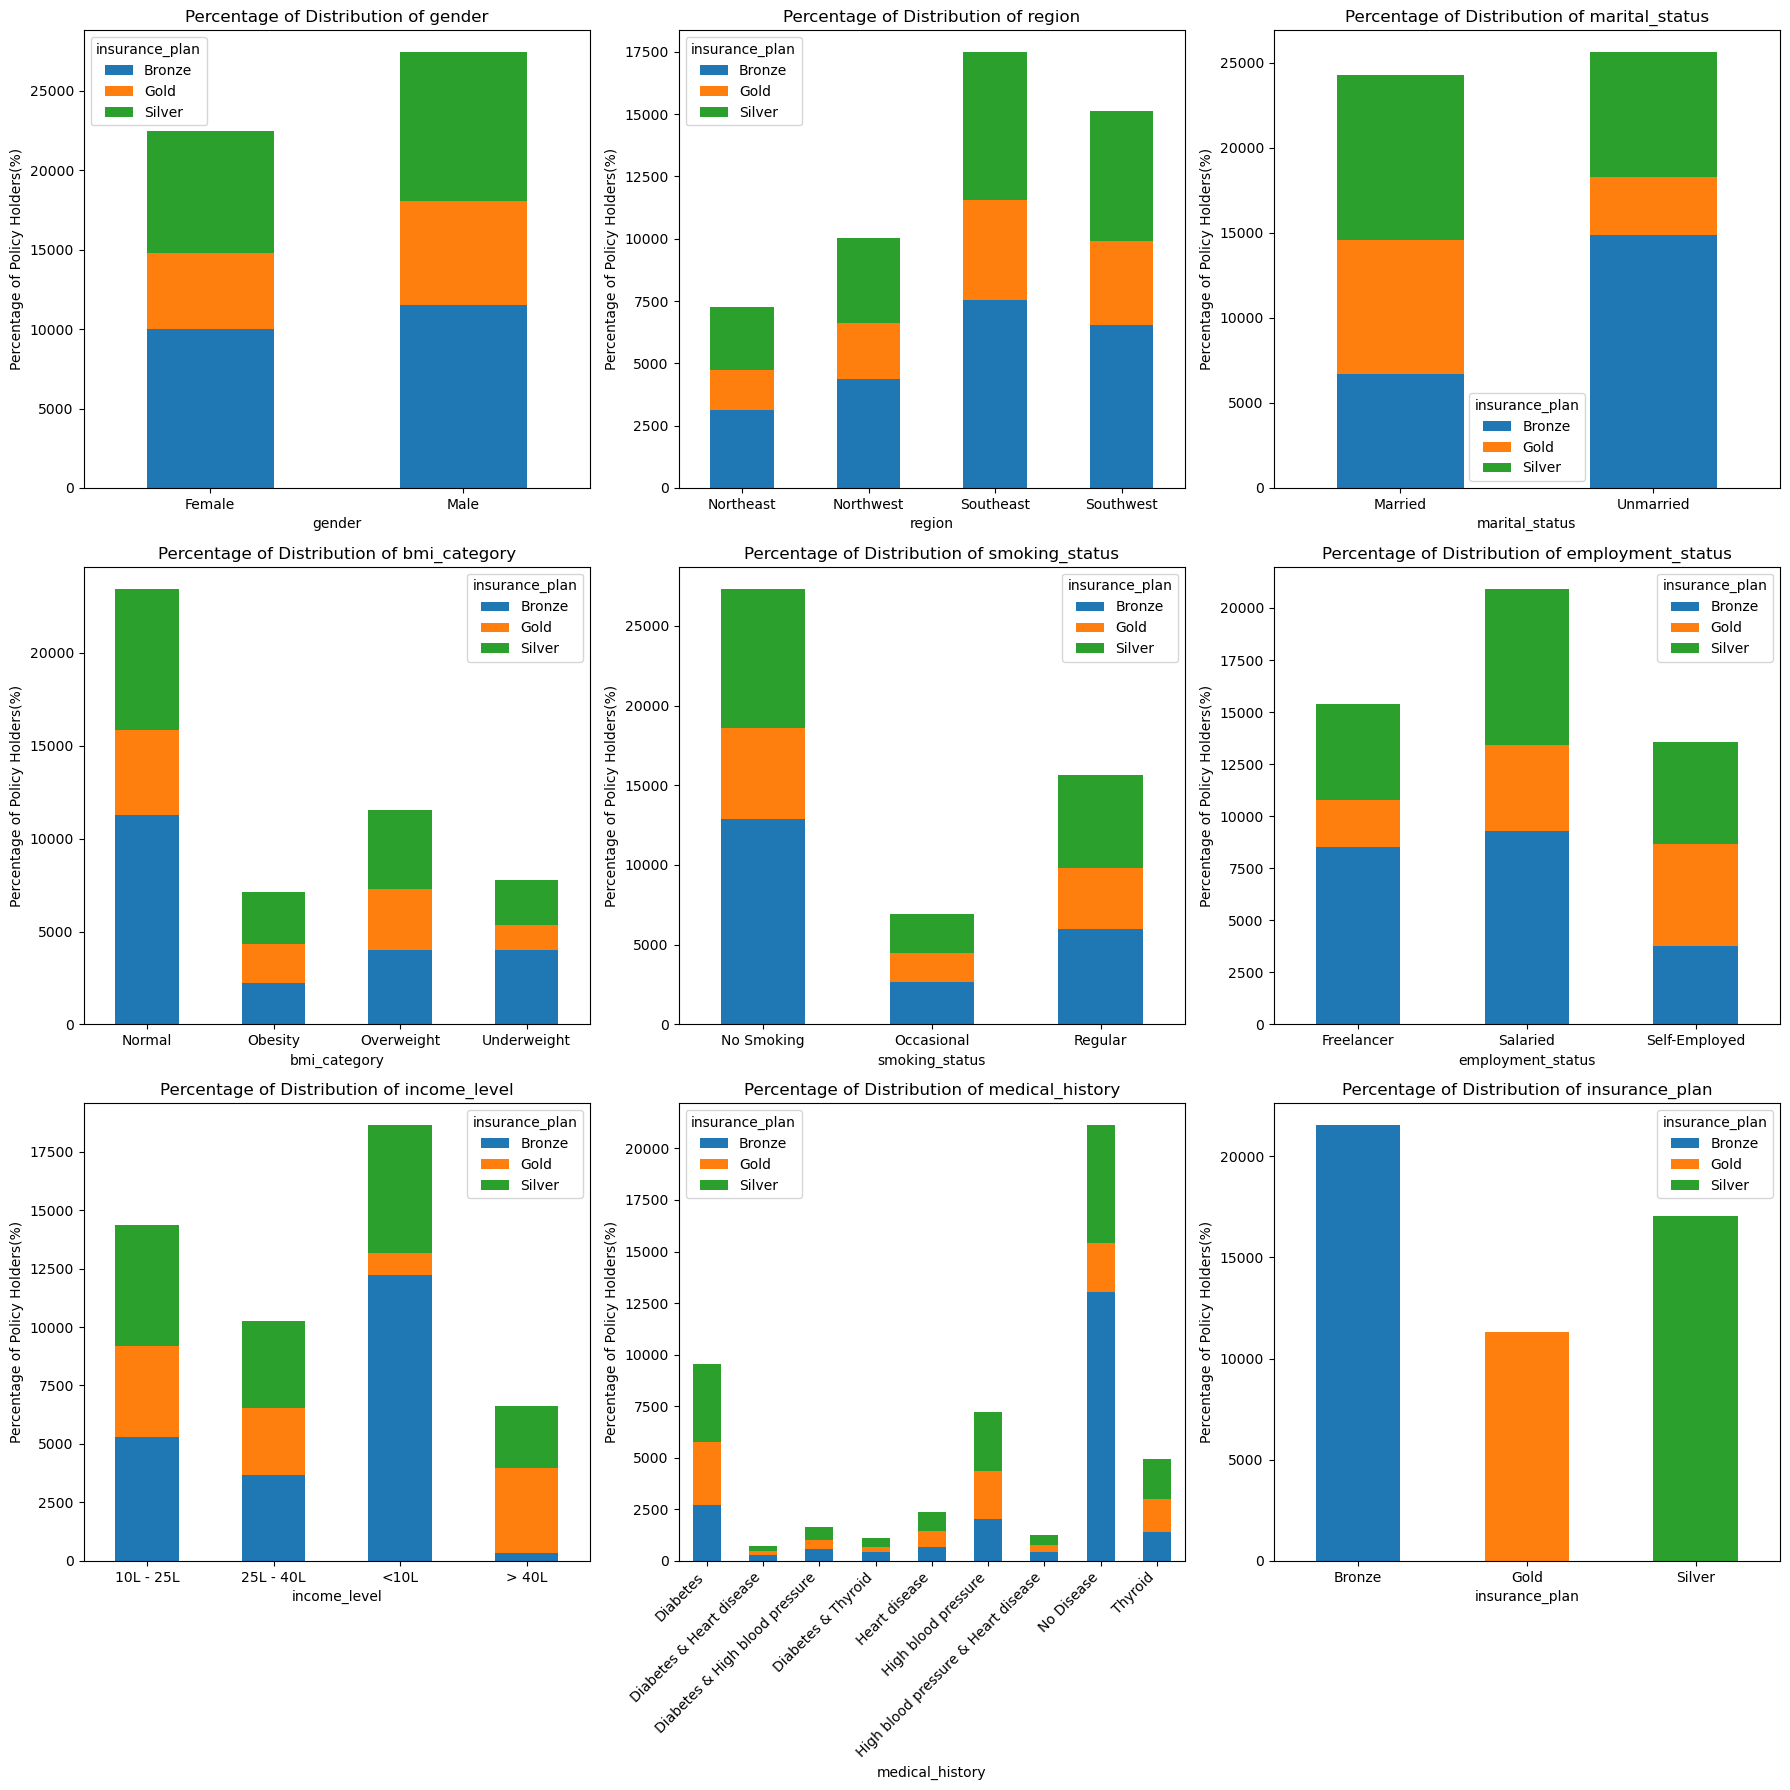

In [185]:
fig, axes=plt.subplots(3,3,figsize=(18,18))
axes=axes.flatten()
bar_color = "#3498db"
for ax , col in zip(axes , categorical_columns):
    # calculating the percentage distribution for each category
    cross_tab=pd.crosstab(df2[col],df2['insurance_plan'])

    #creating bar plots
    cross_tab.plot(kind="bar",ax=ax,stacked=True)
    ax.set_title(f'Percentage of Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage of Policy Holders(%)')
    
    # Rotate x-axis labels if there are too many
    if len(cross_tab) > 7:   
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

insurance_plan      0     1     2
income_level                     
0               12226  5486   931
1                5307  5182  3880
2                3683  3750  2840
3                 329  2641  3653


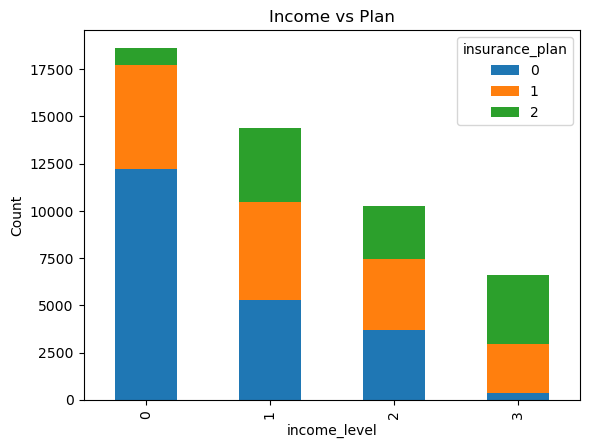

In [186]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df3['income_level'], df3['insurance_plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

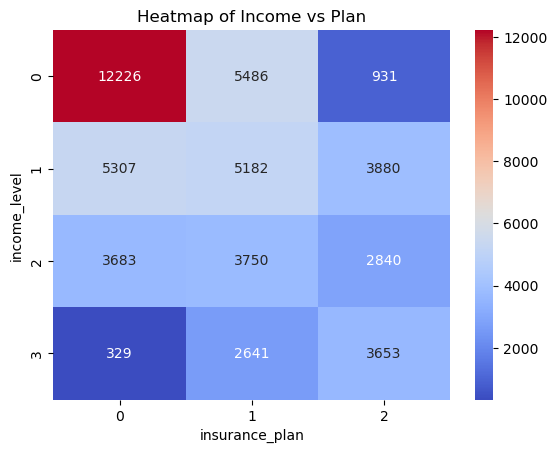

In [187]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

## Feature Enginnering


In [188]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [189]:
## we have more than one values as disease column
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

### Calculating the Risk Score Using the `medical_history` Column

Intuitively, as the number of diseases increases, the insurance amount also tends to increase. To quantify this relationship, we define a **risk score** that helps assess the likelihood of higher medical risks.

After consulting with the business team, the following risk indices were determined for specific medical conditions:

```json
{
  "diabetes": 6,
  "high_blood_pressure": 6,
  "heart_disease": 8,
  "thyroid": 5,
  "no_disease": 0,
  "none": 0
}


In [190]:
risk_scores={
  "diabetes": 6,
  "high blood pressure": 6,
  "heart disease": 8,
  "thyroid": 5,
  "no disease": 0,
  "none": 0
}

In [191]:
# lets split the medical_history column into two columns
# converting to lower case and adding to the dataframe

df2[['disease1','disease2']]=df2['medical_history'].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None


In [192]:
# filling the null values with none
df2.disease1.fillna('none',inplace=True)
df2.disease2.fillna('none',inplace=True)
df2['total_risk_score']=0

# updating the risk score
for disease in ['disease1','disease2']:
    df2['total_risk_score']+=df2[disease].map(risk_scores)

#normalising the risk score
max_score=df2['total_risk_score'].max()
min_score=df2['total_risk_score'].min()
df2['normalized_risk_score']=(df2['total_risk_score']-min_score)/(max_score-min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


### Label encoding for Ordinal Columns

In [193]:
# insurance plan
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':0,'Silver':1,'Gold':2})
df2.insurance_plan.unique()

array([0, 1, 2], dtype=int64)

In [194]:
# lets label encode income level also 
df2['income_level']=df2['income_level'].map({'<10L':0,'10L - 25L':1,'25L - 40L':2,'> 40L':3})
df2.income_level.unique()

array([0, 1, 3, 2], dtype=int64)

### Lets handle nominal columns (OneHot-Encoding)

In [195]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,0,6,Diabetes,0,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,0,6,Diabetes,0,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,1,20,High blood pressure,1,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,3,77,No Disease,2,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,3,99,High blood pressure,1,13365,high blood pressure,none,6,0.428571


In [196]:
nominal_cols=['gender','region','marital_status','bmi_category','smoking_status','employment_status']
df3=pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,0,6,Diabetes,0,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,0,6,Diabetes,0,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,1,20,High blood pressure,1,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,No Disease,2,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,3,99,High blood pressure,1,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [197]:
df4=df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,0,6,0,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,0,6,0,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,1,20,1,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,2,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,3,99,1,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Correlation Matrix Heatmap
-To visualize the correlation between different features in the dataset, we use a **heatmap**. This helps in identifying   
highly correlated features, which can be removed to reduce multicollinearity.

-The heatmap provides a clear view of relationships between features, aiding in better feature selection.

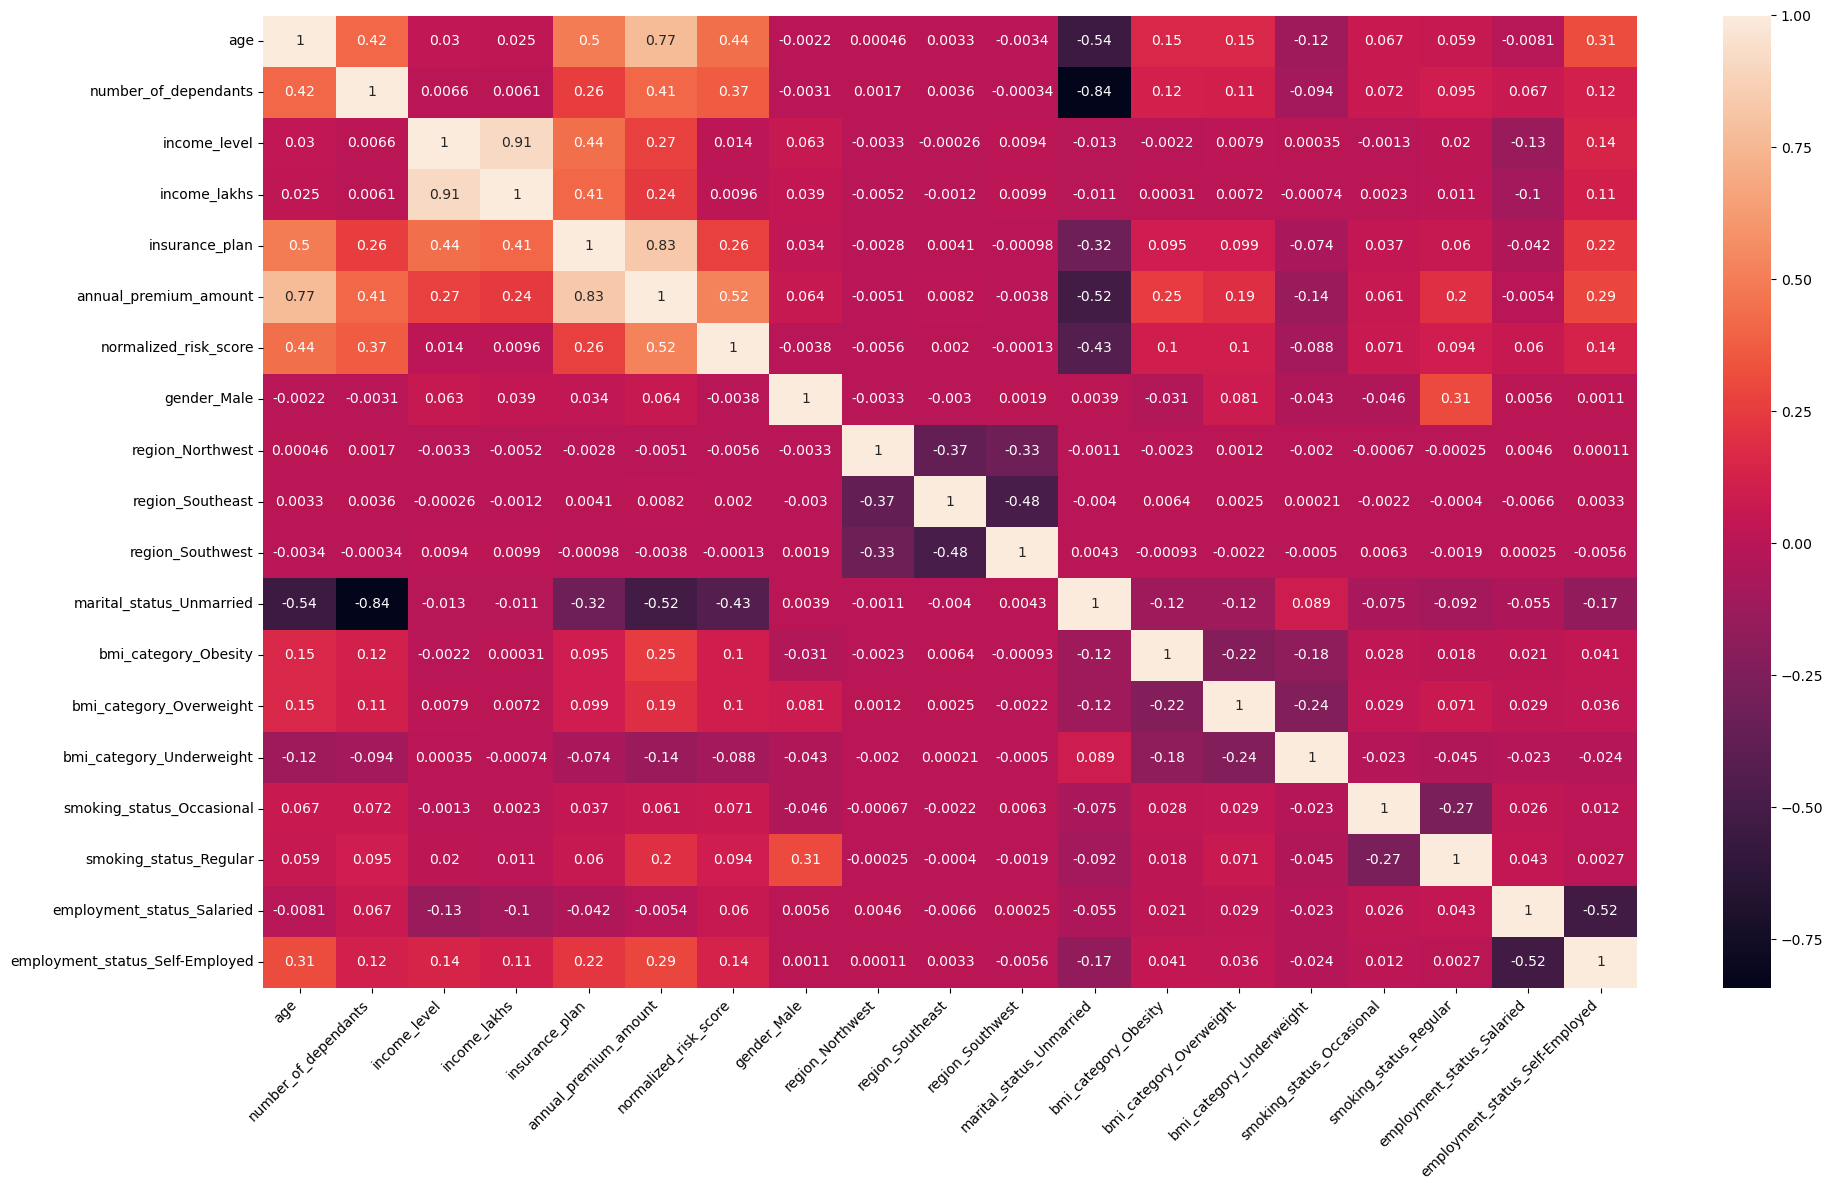

In [198]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

### Feature Scaling(MinMax)

In [199]:
X=df4.drop("annual_premium_amount",axis='columns')
y=df4['annual_premium_amount']

cols_to_scale=['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler()
X[cols_to_scale]=scalar.fit_transform(X[cols_to_scale])
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection Using Correlation Matrix and VIF

Feature selection is crucial for building an efficient machine learning model. One way to choose features is by using a **correlation matrix**, where highly correlated features can be removed to avoid multicollinearity.

However, a better approach is to use **Variance Inflation Factor (VIF)**.

### Variance Inflation Factor (VIF)
VIF helps in identifying multicollinearity by measuring how much the variance of a regression coefficient is inflated due to collinearity among features. Unlike correlation, VIF evaluates the relationship of one feature with all other features in an aggregate way, making it a more reliable method for feature selection.


In [200]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['variable']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data,i) for i in range(data.shape[1])]
    return vif_df

In [201]:
calculate_vif(X)

,variable,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


### Handling Multicollinearity Using VIF

- A **VIF (Variance Inflation Factor) value greater than 10** indicates high multicollinearity between features.
- In our case, **`income_level`** and **`income_lakhs`** have high VIF values, suggesting strong correlation.
- Since these features are essentially conveying the same information, it is best to remove the feature with the highest VIF.
- After removing the feature with the highest VIF, we **recalculate VIF values** to ensure multicollinearity is minimized.

This iterative process helps in selecting the most independent features, leading to a more stable and interpretable model.


In [202]:
calculate_vif(X.drop("income_level",axis='columns'))

,variable,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [203]:
X_reduced=X.drop('income_level',axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


## Model Training

In [204]:
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.3,random_state=41)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_train.shape}')

X_train : (34935, 17)
X_test : (14973, 17)
y_train : (34935,)
y_test : (34935,)


In [205]:
# Lets train Linear regression model
model_lr=LinearRegression()
model_lr.fit(X_train,y_train)
test_score=model_lr.score(X_test,y_test)
train_score=model_lr.score(X_train,y_train)
print(f'train_score : {train_score}')
print(f'test_score : {test_score}')

train_score : 0.9283105380108887
test_score : 0.9278683638592513


### Evaluating Model Fit: Balanced vs. Overfitting

- By analyzing the **training score** and **test score**, we observe that the model achieves a **balanced fit** in this case.
- A balanced fit means the model generalizes well to unseen data, avoiding high variance.
- However, if the **training score is significantly higher than the test score**, it indicates **overfitting**.
  - Overfitting occurs when the model learns patterns specific to the training data but fails to generalize to new data.
  - This can lead to poor performance on test data.

Regularization techniques, feature selection, or increasing training data can help mitigate overfitting and improve model generalization.


In [206]:
from sklearn.metrics import mean_squared_error,r2_score
y_pred=model_lr.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)
print(f'Linear Regression ==> MSE:{mse_lr} : RMSE: {rmse_lr}')

Linear Regression ==> MSE:5120542.486872459 : RMSE: 2262.861570417523


In [207]:
model_lr.intercept_

4786.498250629753

### Feature Importance in Linear Regression

- Unlike some models that provide direct feature importance (e.g., **Decision Trees, Random Forests**), **Linear Regression** does not have a built-in feature importance attribute.
- Instead, feature importance in **Linear Regression** is determined by analyzing the **coefficients** of the model.
- The magnitude of the coefficients indicates the impact of each feature on the target variable.
  - **Higher absolute values** suggest greater influence.
  - **Positive coefficients** indicate a direct relationship, while **negative coefficients** indicate an inverse relationship.

By interpreting these coefficients, we can understand which features contribute most to the model's predictions.


### Key Features Identified by Linear Regression

From the Linear Regression model, we can determine feature importance by analyzing the **coefficients**.  

- The most influential features in our model are:
  - **Insurance Plan**
  - **Age**
  - **Normalized Risk Score**  

These features have the highest absolute coefficient values, indicating their strong impact on the target variable. Understanding these key predictors helps in making informed decisions and improving model interpretability.



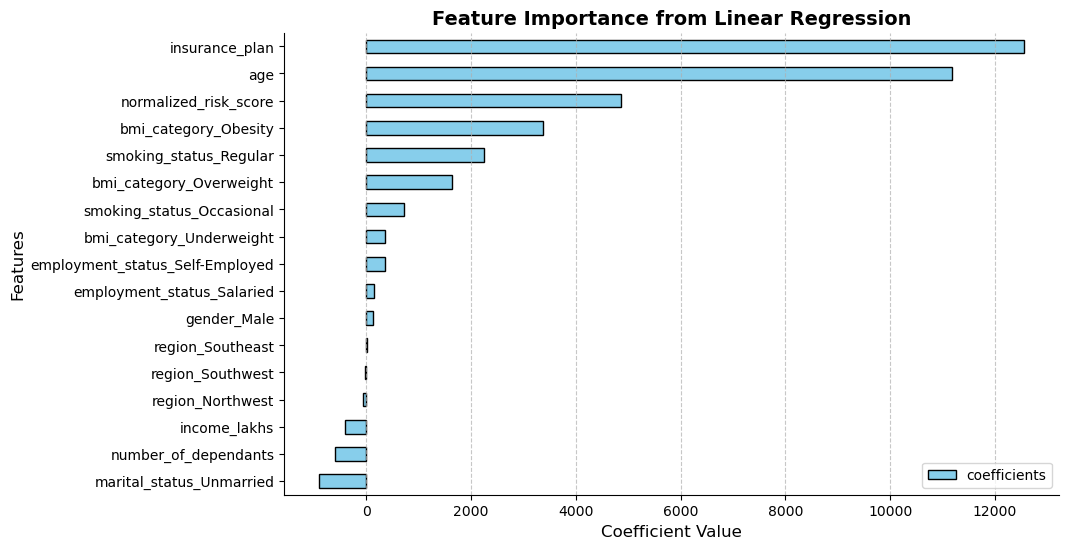

In [208]:
## feature importance
feature_importances=model_lr.coef_
coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df

ax = coef_df.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')


plt.title("Feature Importance from Linear Regression", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Adding gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

### Hyperparameter Tuning and Model Evaluation

To improve model performance, we experiment with different regression models and compare their effectiveness.  

- We define a dictionary of models, including:
  - **Linear Regression**
  - **Lasso Regression** (L1 regularization)
  - **Ridge Regression** (L2 regularization)
  - **Decision Tree Regressor**
  - **Random Forest Regressor**
  - **XGBoost Regressor**

- Each model is trained using the **training dataset** and evaluated on the **test dataset**.
- We calculate:
  - **Train Score**: Measures how well the model fits the training data.
  - **Test Score**: Evaluates how well the model generalizes to unseen data.

By comparing these scores, we can identify the best-performing model and detect **overfitting** (if the train score is significantly higher than the test score).


In [209]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),  # You can adjust alpha
    "Ridge": Ridge(alpha=1.0),  # You can adjust alpha
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror')  # For regression tasks
}
train_scores = []
test_scores = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"{name} - Train Score: {train_score:.4f}, Test Score: {test_score:.4f}")



Linear Regression - Train Score: 0.9283, Test Score: 0.9279
Lasso - Train Score: 0.9283, Test Score: 0.9279
Ridge - Train Score: 0.9283, Test Score: 0.9279
Decision Tree - Train Score: 0.9992, Test Score: 0.9638
Random Forest - Train Score: 0.9966, Test Score: 0.9794
XGBoost - Train Score: 0.9862, Test Score: 0.9809


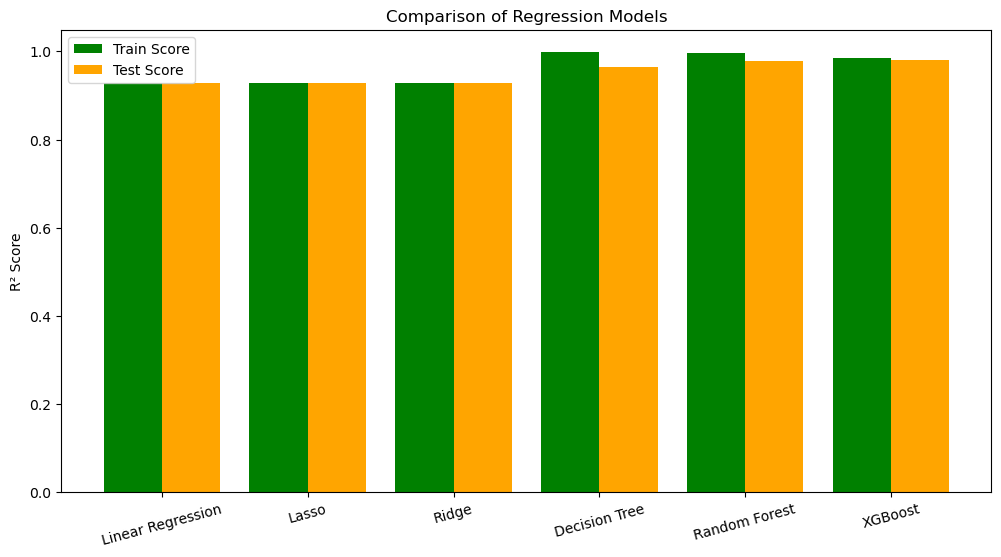

In [210]:
# Visualizing results
x_labels = list(models.keys())
x = np.arange(len(x_labels))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, train_scores, width=0.4, label="Train Score", color='green')
plt.bar(x + 0.2, test_scores, width=0.4, label="Test Score", color='orange')

plt.xticks(x, x_labels, rotation=15)
plt.ylabel("R² Score")
plt.title("Comparison of Regression Models")
plt.legend()
plt.show()

### Selecting the Best Model: XGBoost

From our model comparison, **XGBoost** performed the best with the highest test score:  
- **XGBoost:** Train Score: **0.9862**, Test Score: **0.9809**  
- Other models, such as **Linear Regression, Lasso, and Ridge**, had lower scores, while **Decision Tree and Random Forest** showed signs of overfitting.

### Hyperparameter Tuning for XGBoost

To further optimize XGBoost, we use **RandomizedSearchCV** to find the best hyperparameters.  

- We define a **parameter grid** with key hyperparameters:
  - **`n_estimators`**: Number of boosting rounds (20, 40, 50).
  - **`learning_rate`**: Step size shrinkage (0.01, 0.1, 0.2).
  - **`max_depth`**: Maximum depth of trees (3, 4, 5).

- We use **RandomizedSearchCV** with:
  - **10 iterations**
  - **3-fold cross-validation**
  - **R² scoring metric** to evaluate model performance.

After fitting the model, we extract the **best score**, which indicates the highest performance achieved with the tuned parameters.


In [211]:

model_xgb=XGBRegressor()
param_grid={
    'n_estimators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5]
}
random_search=RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2')
random_search.fit(X_train,y_train)
random_search.best_score_

0.9810435774274541

In [212]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [213]:
best_model=random_search.best_estimator_


### Interpreting Feature Importance in XGBoost

Unlike **Linear Regression**, where feature importance is directly derived from coefficients, **XGBoost** is a tree-based model, making interpretation more complex.

- XGBoost determines **feature importance** based on how often a feature is used to **split the data** across all trees in the ensemble.
- Common methods to interpret feature importance in XGBoost include:
  - **Gain**: Contribution of a feature to model improvement when used for splitting.
  - **Weight**: Number of times a feature is used in splits.
  - **Cover**: Number of samples affected by a feature split.

By analyzing feature importance in XGBoost, we can identify which features have the most impact on model predictions.


---


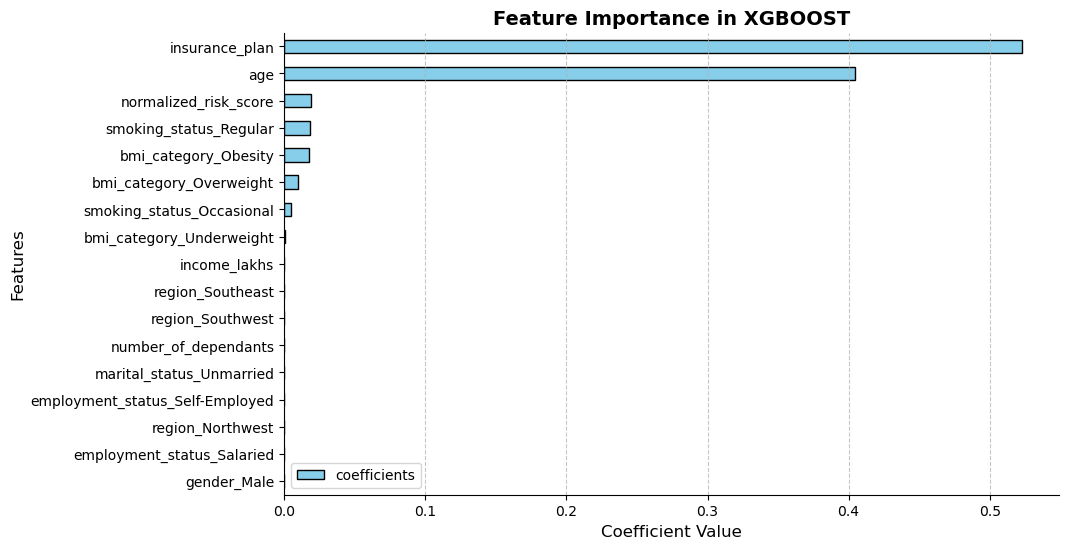

In [214]:
## feature importance
feature_importances=best_model.feature_importances_

coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df

ax = coef_df.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Feature Importance in XGBOOST", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

###

## Is a 98% R² Score Really Enough?

While an **R² score of 98%** indicates that the model explains most of the variance in the target variable, it is essential to evaluate whether this is truly sufficient.  

### Key Considerations:
- **Overfitting:** A very high R² score might suggest the model is too closely fitted to the training data, potentially reducing generalizability.
- **Business Context:** Even a 98% R² might not be enough if small prediction errors lead to significant real-world consequences (e.g., in finance or healthcare).
- **Error Analysis:** Instead of relying solely on R², it's important to analyze residual errors to understand model limitations.

---

## Error Analysis

To ensure our model is performing well:
- **Check Residuals**: Residual plots should show a random distribution without clear patterns.
- **Evaluate RMSE & MAE**: Lower values indicate better predictive performance.
- **Identify Outliers**: Extreme errors could indicate data inconsistencies or model weaknesses.
- **Check Bias & Variance**: Ensure the model balances bias (underfitting) and variance (overfitting).

By conducting thorough **error analysis**, we can validate whether the model is genuinely reliable and where improvements can be made.


In [215]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=(residuals*100)/y_test

results_df=pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'residuals':residuals,
    'diff_pct':residuals_pct
})
results_df.head()

,actual,predicted,residuals,diff_pct
34444,11052,12002.197266,950.197266,8.597514
5880,24411,24223.884766,-187.115234,-0.766520
32278,18314,18901.699219,587.699219,3.209016
21217,12748,10720.790039,-2027.209961,-15.902180
15217,8847,6680.455566,-2166.544434,-24.489029


### Error Analysis: Distribution of Errors

We analyzed the **percentage difference (diff_pct)** between actual and predicted values. Upon plotting the distribution of errors, we found that the spread ranged from **-25% to +80%**, indicating a **very high error margin**.

After consulting with the team, it was made clear that the acceptable error margin should be within **10%**. 

To address this:
- We set an **extreme error threshold** of 10%.
- We filtered the results to identify predictions with a **percentage difference** exceeding this threshold.




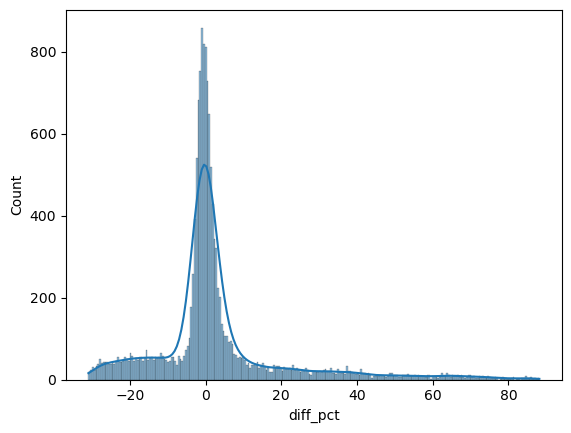

In [216]:
### visualise the residuals_pct

sns.histplot(results_df.diff_pct,kde=True)
plt.show()

In [217]:
### After enquiring to the team we are informed that we need to make sure the error % margin in just 10%

extreme_error_threshold=10
extreme_results_df=results_df[abs(results_df['diff_pct'])>extreme_error_threshold]
extreme_results_df.shape

(4479, 4)

In [218]:
results_df.shape

(14973, 4)

In [219]:
extreme_errors_pct=extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

29.913844920857542

In [220]:
results_df[abs(results_df['diff_pct'])>50].sort_values('diff_pct',ascending=False)


,actual,predicted,residuals,diff_pct
36269,3501,6587.399902,3086.399902,88.157666
29904,3503,6587.399902,3084.399902,88.050240
624,3505,6587.399902,3082.399902,87.942936
46118,3508,6587.399902,3079.399902,87.782209
25207,3501,6562.967773,3061.967773,87.459805
...,...,...,...,...
8377,4860,7297.373047,2437.373047,50.151709
42852,4389,6587.399902,2198.399902,50.088856
16876,4457,6688.545898,2231.545898,50.068340
16908,4699,7051.131348,2352.131348,50.055998


### Analyzing Subsets of Data with Extreme Errors

To gain deeper insights into where the errors are occurring, we analyze the **distribution of features** between the overall dataset and the subset with **extreme errors**.

We first retrieve the relevant data from `X_test` corresponding to the indexes of **extreme errors**.



In [221]:

# get more columns
X_test.index

Index([34444,  5880, 32278, 21217, 15217, 35188, 32800, 41930,  4127, 22586,
       ...
        9861, 38290, 39050, 26169,  9700, 44317, 36438, 49655, 34546, 30019],
      dtype='int64', length=14973)

In [222]:
extreme_errors_df=X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
21217,0.074074,0.0,0.757576,0.5,0.000000,1,0,1,0,1,0,0,0,0,1,0,1
15217,0.074074,0.0,0.141414,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,1,0
32800,0.037037,0.0,0.040404,0.0,0.000000,1,0,0,0,1,1,0,0,0,0,0,0
41930,0.000000,0.0,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,0,0,1
22586,0.425926,0.6,0.040404,0.0,0.428571,0,0,1,0,0,0,0,0,0,0,1,0


### Comparing Error Distributions

Next, we compare the **distribution of features** in the subset of data with extreme errors against the original distribution of the entire dataset. By doing so, we aim to identify if there are specific features or subsets of the data where the model is underperforming.

We use **histograms with kernel density estimates (KDE)** to visualize and compare the distributions for each feature:
- **Overall distribution** of features from `X_test`.
- **Distribution of features** with extreme errors from `extreme_errors_df`.

This comparison allows us to pinpoint which features or data subsets contribute to the higher error margins, helping in identifying areas for model improvement.


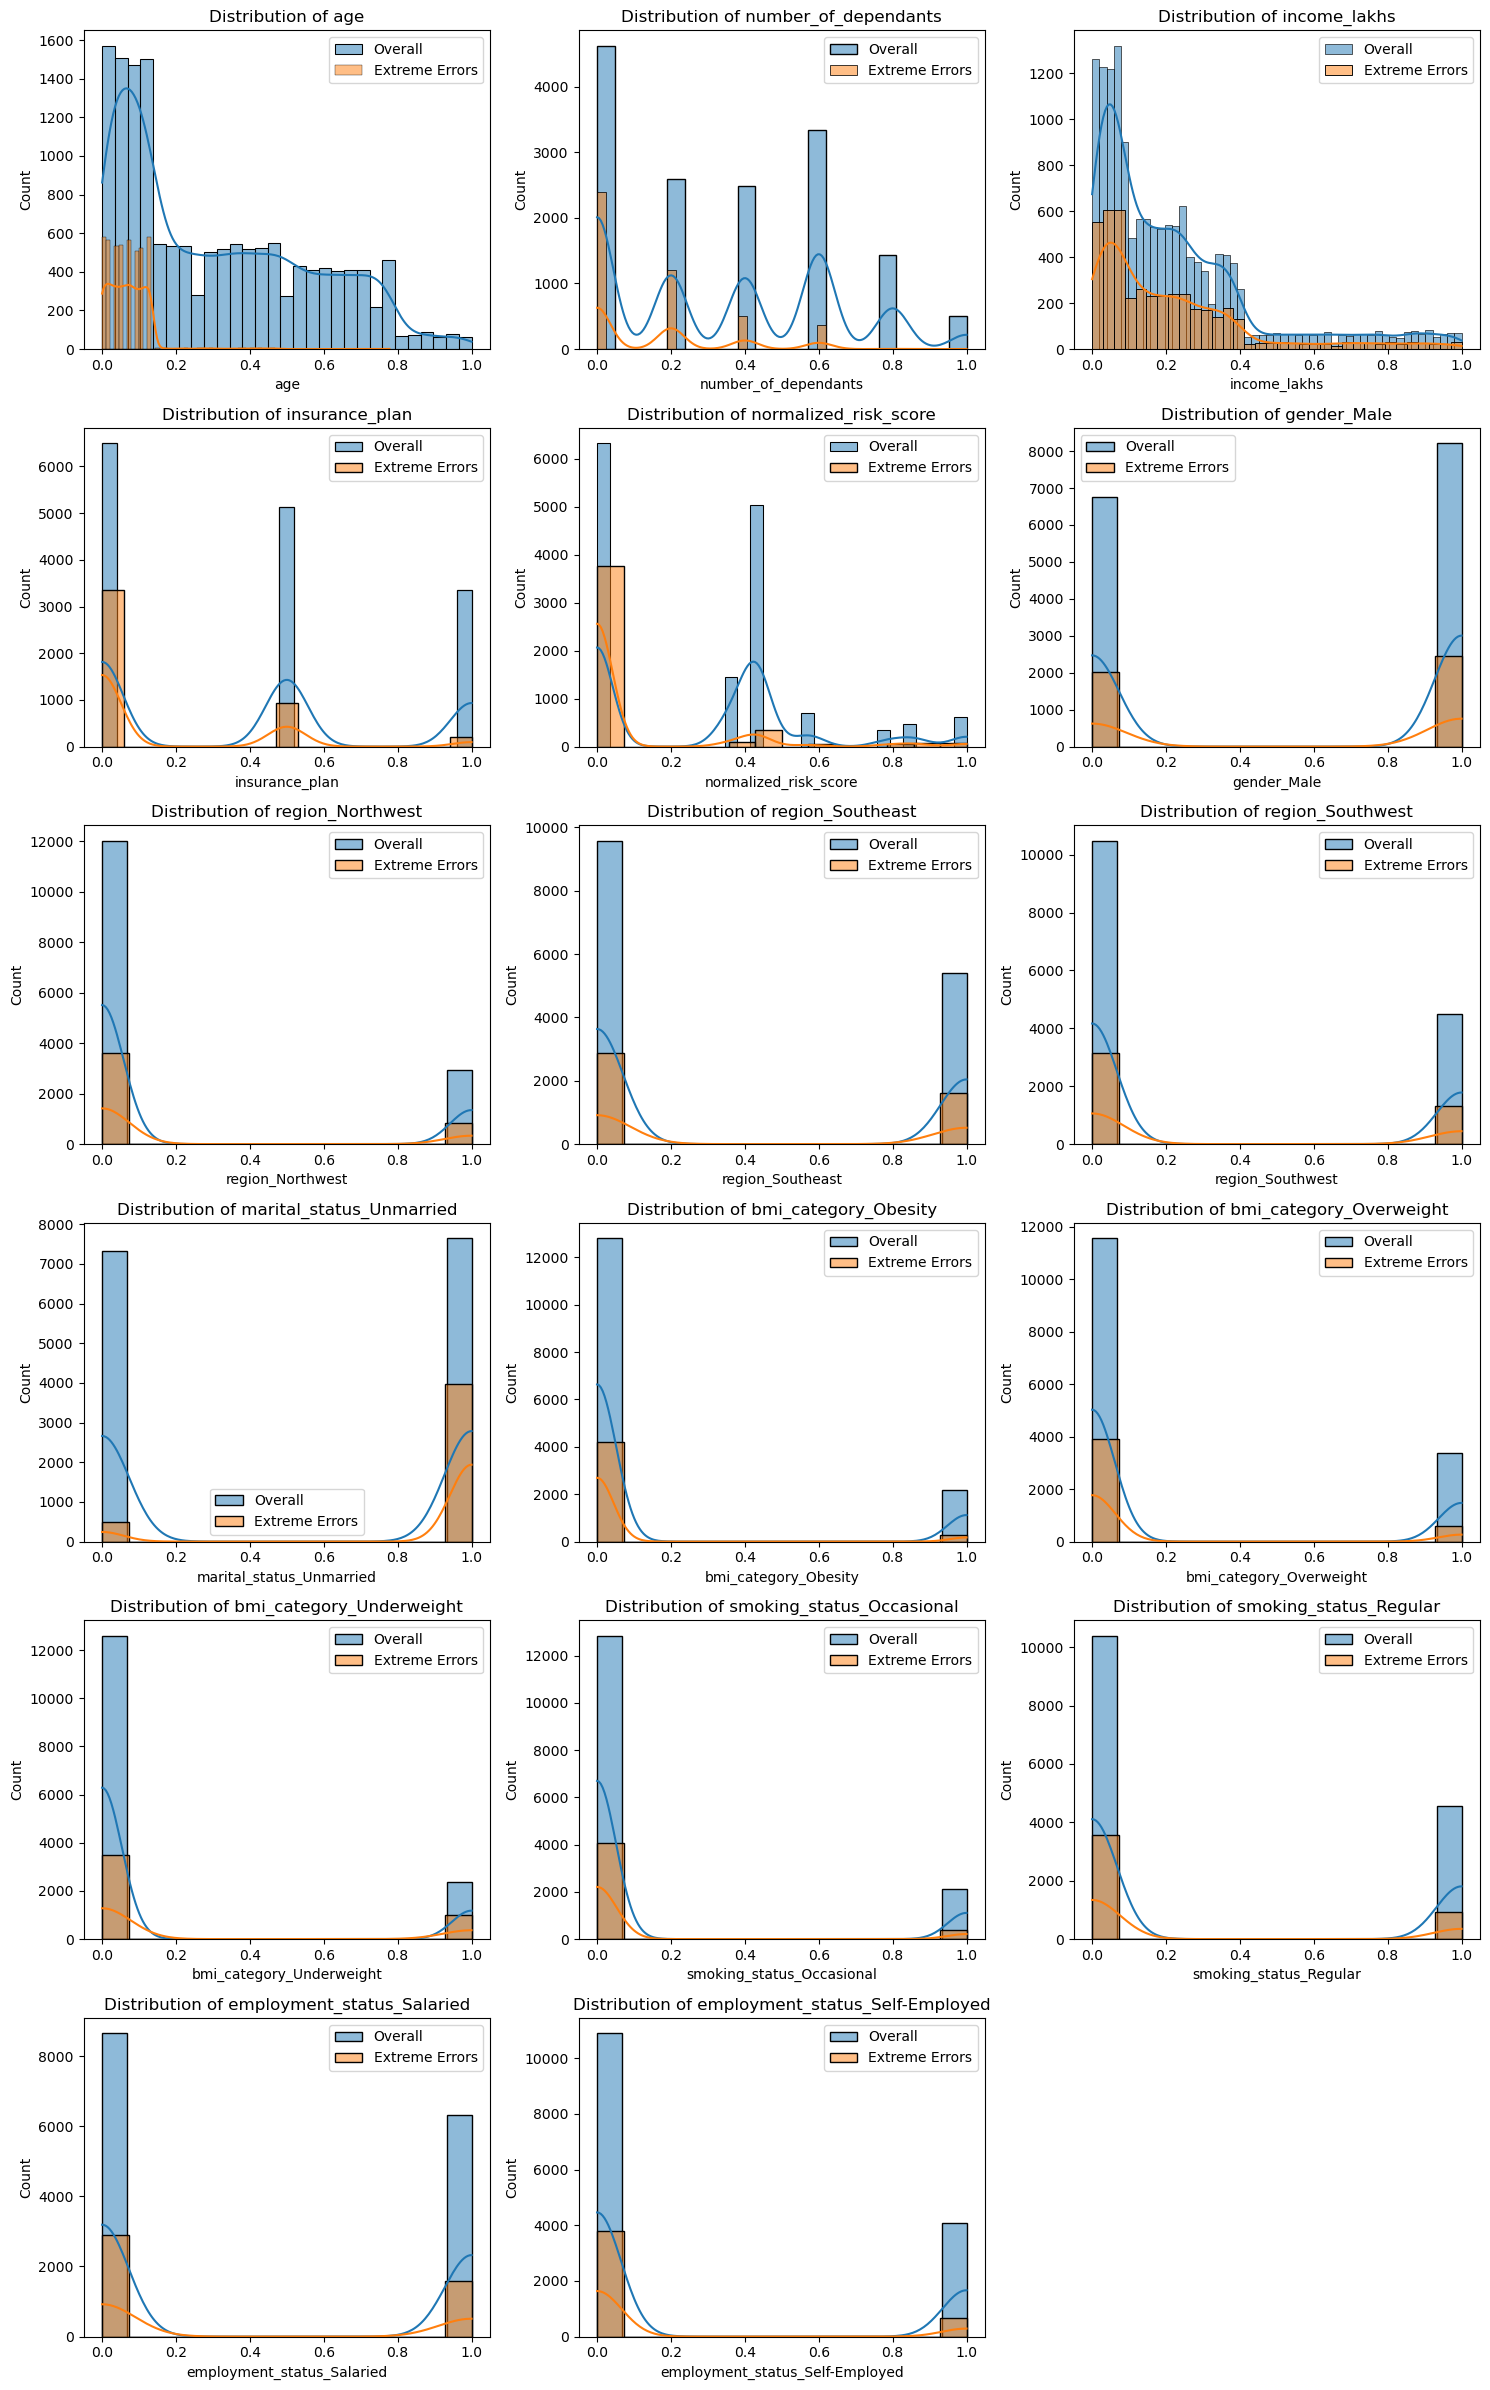

In [223]:
num_features = len(X_test.columns)
num_cols = 3  # You can adjust the number of columns
num_rows = int(np.ceil(num_features / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot each feature
for i, feature in enumerate(X_test.columns):
    ax = axes[i]
    sns.histplot(X_test[feature], label='Overall', kde=True, ax=ax)
    sns.histplot(extreme_errors_df[feature], label="Extreme Errors", kde=True, ax=ax)
    ax.legend()
    ax.set_title(f'Distribution of {feature}')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Investigating Age Group and Error Percentage

It appears that the **age group** may be contributing to the extreme error percentage. Upon comparing the distribution of **normal data** and **errors**, we observe that they do not look the same. This discrepancy suggests that the model may be struggling with specific age groups.

### Next Steps:
- We will explore which specific **age group** has a higher error percentage and investigate why the model is performing poorly in these cases.
- By analyzing the distribution of errors for different **age groups**, we can pinpoint if the model's performance is significantly worse for certain segments of the data.

This analysis will help us identify potential issues and tailor the model to handle specific age groups more effectively.


In [224]:
## lets inverse trasform age 
extreme_errors_df['income_level']=-1
df_reversed=pd.DataFrame()
df_reversed[cols_to_scale]=scalar.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4479.000000,4479.000000,4479.0,4479.000000,4479.000000
mean,21.749274,0.748828,-3.0,21.754856,0.299844
std,3.233486,0.970355,0.0,21.290662,0.550348
min,18.000000,0.000000,-3.0,1.000000,0.000000
25%,19.000000,0.000000,-3.0,6.000000,0.000000
50%,22.000000,0.000000,-3.0,15.000000,0.000000
75%,24.000000,1.000000,-3.0,30.000000,1.000000
max,60.000000,5.000000,-3.0,100.000000,2.000000


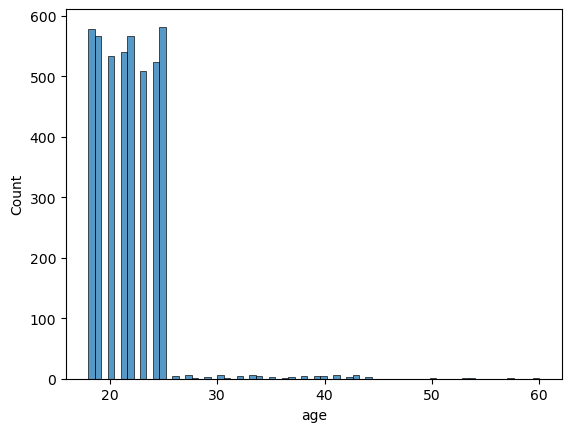

In [225]:
## let visulaise histplot of age group 
sns.histplot(df_reversed.age)
plt.show()

### Identifying the Age Group with Most Errors

After further investigation, it is confirmed that the **age group less than 25** is where we encountered the highest number of errors. This group appears to be significantly contributing to the extreme error percentages.

### Key Insights:
- The **distribution of errors** for this age group is notably different from the rest of the dataset.
- The model seems to be underperforming when predicting outcomes for individuals under 25, suggesting that **age** might be an important feature to reconsider or handle differently for this subset.


In [226]:
df_reversed["age"].quantile(0.97) ## 97% of extreme error data points are in the age group between (18, 25) only

25.0

## Model Segmentation

In real-world machine learning applications, there is no one-size-fits-all solution for most use cases. To address different scenarios, we may employ **model segmentation**, which involves creating distinct models for different subsets of data. This practice can significantly improve model performance when certain patterns or errors are more prevalent in specific groups.

---

When there's no clear pattern of error across the entire dataset, you can reduce errors by:
- **Trying different feature engineering techniques** tailored to each subset.
- **Collecting more data** to improve model training for the identified groups.

---

### Let's create two machine learning models:

1. **Model A**: Trained on **Dataset (Age <= 25)**  
   - Since most of the errors are concentrated in this age group, we will focus on improving the predictions for this subset.  
   - This model is being developed in the notebook: `ml_premium_health_insurance_prediction_young_with_gr.ipynb`

2. **Model B**: Trained on **Dataset (Age > 25)**  
   - This model will be optimized for the other age group, where the error rate is significantly lower.  
   - This model is being developed in the notebook: `ml_premium_health_insurance_prediction_rest_with_gr.ipynb`

By segmenting the data this way, we can target the high-error age group separately and improve overall model performance.
